In [ ]:
# In this notebook, I am fitting the probebility plots for the clustering project using pymc.

In [31]:
import numpy as np
import pandas as pd

import emcee

import pylab as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams['figure.figsize'] = (32, 20)

#import gerdist

# This loads the data and turns it to M200c[Msun]

In [3]:
#program params
no_runs=10
zboundry=0.51

cent_bin_edges=np.linspace(12.28,16.04,48)
cent_bin_cents=cent_bin_edges[1:]-(cent_bin_edges[1]-cent_bin_edges[0])/2.
#sat_bin_edges=np.linspace(,15.7,10)
#sat_bin_cents=sat_bin_edges[1:]-(sat_bin_edges[1]-sat_bin_edges[0])/2.

#load data
dataM,dataP=np.loadtxt('/home/swb1g09/Clustering_project/dpdlgm_mcmc_dr10_z0.400.60_ms11.5.dat', usecols=(0,2),unpack=True,skiprows=1)
datasatP=np.loadtxt('/home/swb1g09/Clustering_project/dpdlgm_mcmc_dr10_z0.400.60_ms11.5.dat', usecols=(3,),unpack=True,skiprows=1)

ss=(np.arange(0,47)%2).astype(bool)
dataM_sats=dataM[ss]
dataP_sats=datasatP[ss]
sat_bin_cents=dataM_sats
dif=sat_bin_cents[1]-sat_bin_cents[0]
sat_bin_edges=sat_bin_cents-dif/2.
sat_bin_edges=np.append(sat_bin_edges,[sat_bin_edges[-1]+dif])


#load redshift steps
a,z=np.loadtxt('/home/swb1g09/Bolshoi_stuff/all_catalogues/db_haloes/a.list',usecols=(0,1),skiprows=1,unpack=True,delimiter=',')

#load halo catalogues
Cents=pd.read_csv('/home/swb1g09/Clustering_project/PerViola_zCen0.5_new_2.dat',delim_whitespace=True)
Sats=pd.read_csv('/home/swb1g09/Clustering_project/PerViola_zSatParent0.5_new4.dat',delim_whitespace=True)

#clean up the halo catalogues

Cents['M200b']/=0.7
Cents['M200c']/=0.7

Sats['M200b']/=0.7
Sats['M200c']/=0.7
Sats['M200b_inf']/=0.7
Sats['M200c_inf']/=0.7
Sats['M200b_host']/=0.7
Sats['M200c_host']/=0.7

# The moster 2013 Mstar-Mhalo relation

In [4]:
def Moster13(M,z,gamma0,sigma):   
    m1=10**(11.59+1.195*(z/(1.+z)))
    N=0.0351-0.0247*(z/(1.+z))
    beta=1.376-0.826*(z/(1.+z))                   
    gamma=gamma0+0.329*(z/(1.+z))
    return (M*2.*N/((M/m1)**-beta+(M/m1)**gamma))*10**np.random.normal(0.,sigma,len(M))



# This cell defines the boundry at which a satellite at z_infall will be an LRG or not at z=0.5

right now, I am just doing frozen so log Mboundry = 11.45 at all z

In [5]:
#this defines the boundry where at high z where a satellite will be an LRG at z=0

m_sat_boundry=np.ones(len(z))*11.45
d={'BoundryMass' : m_sat_boundry, 'z_inf': z}
Boundry=pd.DataFrame(d)

Sats=pd.merge(Sats,Boundry,right_on='z_inf',left_on='z_inf',sort=False,copy=False,how='left')


# This is the main model which takes in gamma and sigma and calculates dp/dlnM for cents and sats.

In [6]:
def model(gamma05,gamma,sigma05,sigma,stripping):
    #print("start")
    cent_P=[np.zeros(len(cent_bin_cents))]
    sat_P=[np.zeros(len(sat_bin_cents))]
    satfrat=0
    ncen=0
    nsat=0

    for i in range(0,no_runs):
        Sats.loc[Sats.z_inf >= zboundry, 'gamma'] = gamma05
        Sats.loc[Sats.z_inf < zboundry, 'gamma'] =  gamma
        Cents.loc[:,'mstar']=pd.Series(Moster13(Cents['M200c'].values,0.5052306766,gamma,sigma),index=Cents.index)
        #Cents.loc[:,'mstar']=pd.Series(Moster13(Cents['M_vir_inf'].values,Cents['z_inf'].values,0.4,0.15),index=Cents.index)
        Sats.loc[:,'mstar']=pd.Series(Moster13(Sats['M200c_inf'].values,Sats['z_inf'].values,Sats['gamma'].values,sigma05),index=Sats.index)
        Cents_LRGs=Cents.query('mstar > 10**11.45')
        Sats_LRGs=Sats.query('mstar > (10**BoundryMass)/'+str(stripping))
        if len(Cents_LRGs.index)>0:
            ncen+=len(Cents_LRGs.index)
            p=np.histogram(np.log10(Cents_LRGs['M200b'].values),bins=cent_bin_edges,density=False)[0]
            norm=1./(cent_bin_edges[1]-cent_bin_edges[0])/np.sum(p)
            if(np.sum(p))==0:
                print(np.sum(m_star_cents>11.5), p, norm, Cents_LRGs['Mstar'], Cents_LRG['M_vir_inf'])
            cent_P=np.append(cent_P,[(p*norm)],axis=0)

            if len(Sats_LRGs.index)>0:  
                q=np.histogram(np.log10(Sats_LRGs['M200b_host'].values),bins=sat_bin_edges,density=False)[0]
                #print(len(sat_P[0]))
                #print(len([q*norm][0]))                
                sat_P=np.append(sat_P,[q*norm],axis=0)
                satfrat+=float(np.sum(q))/float(np.sum(p))
                nsat+=len(Sats_LRGs.index)
            else:
                sat_P=np.append(sat_P,[np.zeros(len(sat_bin_cents))],axis=0)
        else:
            cent_P=np.append(cent_P,[np.zeros(len(cent_bin_cents))],axis=0)
            sat_P=np.append(sat_P,[np.zeros(len(sat_bin_cents))],axis=0)
    #return cent_P.sum(axis=0)/no_runs,sat_P.sum(axis=0)/no_runs,cent_P.std(axis=0),sat_P.std(axis=0)
    #print(dataP_sats,nsat,(dataP_sats/nsat)**0.5)
    #print(ncen,nsat)
    return cent_P.sum(axis=0)/no_runs,sat_P.sum(axis=0)/no_runs,0.1*(1./(dataP+10.))**0.3,0.003*(1./(dataP_sats+0.05))**0.3

# This is a quick test to check the model for gamma=0.5 and sigma=0.1

[ 0.00736937  0.00736935  0.00736925  0.00736875  0.00736667  0.00735928
  0.0073372   0.00728213  0.0071696   0.00698568  0.0067503   0.00651962
  0.00635813  0.00631416  0.00640648  0.00662026  0.00689748  0.0071437
  0.00729283  0.00735197  0.00736688  0.00736916  0.00736936]


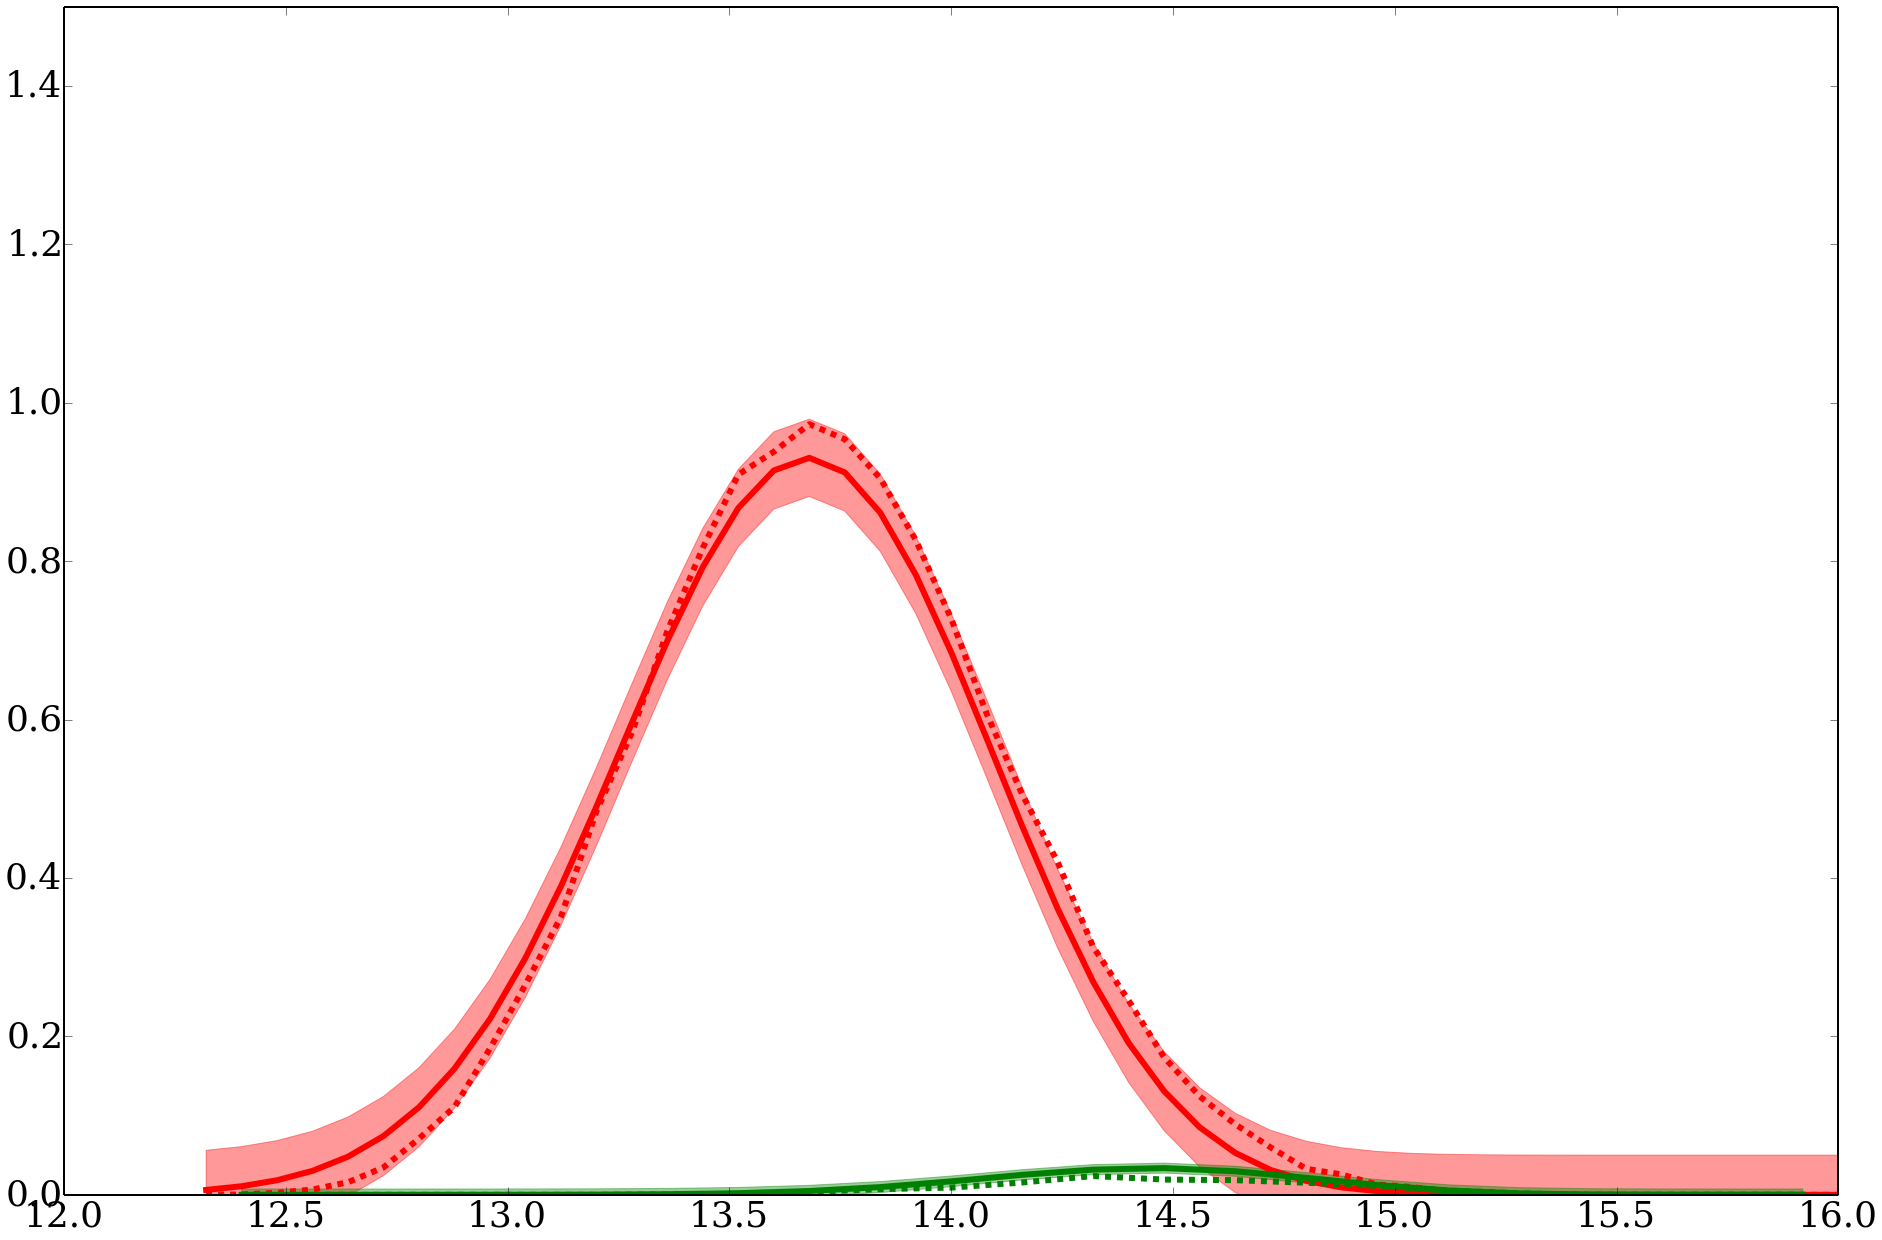

In [7]:
sel_color='r'
sel_color2='g'

#cents_mean,sats_mean,cents_std,sats_std=model(0.6,0.55,0.1,0.15)
cents_mean,sats_mean,cents_std,sats_std=model(0.55,0.48,0.14,0.16,0.9)
#cents_mean,sats_mean,cents_std,sats_std=model(0.55,0.55,0.16,0.16)

plt.plot(cent_bin_cents,cents_mean,linestyle="--",color=sel_color,label=1-0.5)
plt.plot(cent_bin_cents,dataP,linestyle="-",color=sel_color,label=1-0.5)
plt.fill_between(cent_bin_cents,dataP+cents_std,dataP-cents_std,color=sel_color,alpha=0.4)
plt.plot(sat_bin_cents,sats_mean,linestyle="--",color=sel_color2,label=1-0.5)
plt.plot(sat_bin_cents,dataP_sats,linestyle="-",color=sel_color2,label=1-0.5)
plt.fill_between(sat_bin_cents,dataP_sats+sats_std,dataP_sats-sats_std,color=sel_color2,alpha=0.4)
plt.ylim(0,1.5)
print(sats_std)

# This is the clever bit which does the MCMC

In [10]:
sig_offset=0.01

def chi(y,mody,stdy):
    #stdy=np.ones(len(mody))
    try:
        chisq=np.sum(((y-mody)/(stdy+sig_offset))**2)
        return chisq
    except:
        return np.inf

def lnlike(theta):
    gamma,gamma05,sigma,sigma05,strip=theta
    cents_mean,sats_mean,cents_std,sats_std=model(gamma05,gamma,sigma05,sigma,strip)
    return -(chi(dataP,cents_mean,cents_std)+chi(dataP_sats,sats_mean,sats_std))
    
def lnprior(theta):
    #theta=[theta[0],theta[1],theta[2],0.1]
    gamma,gamma05,sigma,sigma05,strip = theta
    if 0.25 < gamma05 < 0.75 and 0.25 < gamma < 0.75 and 0.001< sigma05 < 0.4 and 0.001 < sigma < 0.4 and 0.<=strip<1.0 and gamma05>gamma-0.1:
        #print(theta,"inside")
        return 0.0
    else:
        #print(theta, "outside")
        return -np.inf
    

def lnprob(theta):
    #theta=[theta[0],0.55,0.1,0.1]
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    #print(lp + lnlike(theta))
    return lp + lnlike(theta)


ndim, nwalkers = 5, 16
#ndim, nwalkers = 2, 4
pos = [[0.6,0.6,0.1,0.1,0.9] + 3e-2*np.random.randn(ndim) for i in range(nwalkers)]
#pos = [[0.6,0.1] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
#print(pos)
for i in pos:
    print(i,lnprior(i))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=8)
sampler.run_mcmc(pos, 1000)

[ 0.55693358  0.62447808  0.14313015  0.10276277  0.9494575 ] 0.0
[ 0.58509746  0.54689239  0.05512763  0.11002223  0.89273962] 0.0
[ 0.64297414  0.58878627  0.07614404  0.13250044  0.93502542] 0.0
[ 0.60439769  0.58029168  0.07266276  0.11397599  0.9724522 ] 0.0
[ 0.60036568  0.62052203  0.10279705  0.08120251  0.88576171] 0.0
[ 0.5410807   0.61901442  0.10709153  0.1178367   0.92789895] 0.0
[ 0.60777878  0.65454664  0.14372172  0.07013622  0.88284196] 0.0
[ 0.58269521  0.571486    0.10296252  0.09363703  0.87436018] 0.0
[ 0.66092276  0.60698685  0.04228709  0.10835506  0.91875097] 0.0
[ 0.57438965  0.65854977  0.12537042  0.13265443  0.90423863] 0.0
[ 0.54033332  0.58744459  0.15732379  0.08335063  0.924566  ] 0.0
[ 0.62464322  0.60969897  0.10812183  0.11609739  0.90286546] 0.0
[ 0.56244288  0.58257563  0.15558413  0.09525219  0.8626044 ] 0.0
[ 0.65016975  0.66250883  0.05978114  0.12128791  0.88783203] 0.0
[ 0.62048025  0.58093544  0.10055399  0.11136283  0.93655482] 0.0
[ 0.537215

(array([[ 0.47888534,  0.4427986 ,  0.16495298,  0.21267501,  0.49962229],
        [ 0.48973108,  0.44416955,  0.16918097,  0.1679676 ,  0.6342701 ],
        [ 0.49276149,  0.4305965 ,  0.17319337,  0.17287232,  0.58818859],
        [ 0.48739054,  0.5140842 ,  0.16790948,  0.14987434,  0.81287911],
        [ 0.47721984,  0.42661568,  0.16680881,  0.18111993,  0.57501078],
        [ 0.49033345,  0.5768648 ,  0.16838687,  0.20358898,  0.78501077],
        [ 0.48864885,  0.49460696,  0.17180304,  0.12191598,  0.87467648],
        [ 0.49729915,  0.54788644,  0.16956717,  0.11305417,  0.99629056],
        [ 0.68329982,  0.608242  ,  0.02450609,  0.13054445,  0.94998953],
        [ 0.48003163,  0.45977293,  0.16983983,  0.18805667,  0.57083137],
        [ 0.48787812,  0.49933117,  0.16638934,  0.18708024,  0.66957586],
        [ 0.4920665 ,  0.45868245,  0.17325206,  0.18691115,  0.58969455],
        [ 0.4838392 ,  0.53759084,  0.16821748,  0.12450743,  0.94504802],
        [ 0.48874938,  0.

# This plots the MCMC result

[ 0.55693358  0.58509746  0.64297414  0.60439769  0.60036568  0.5410807
  0.60777878  0.58269521  0.66092276  0.57438965  0.54033332  0.62464322
  0.56244288  0.65016975  0.62048025  0.53721537]


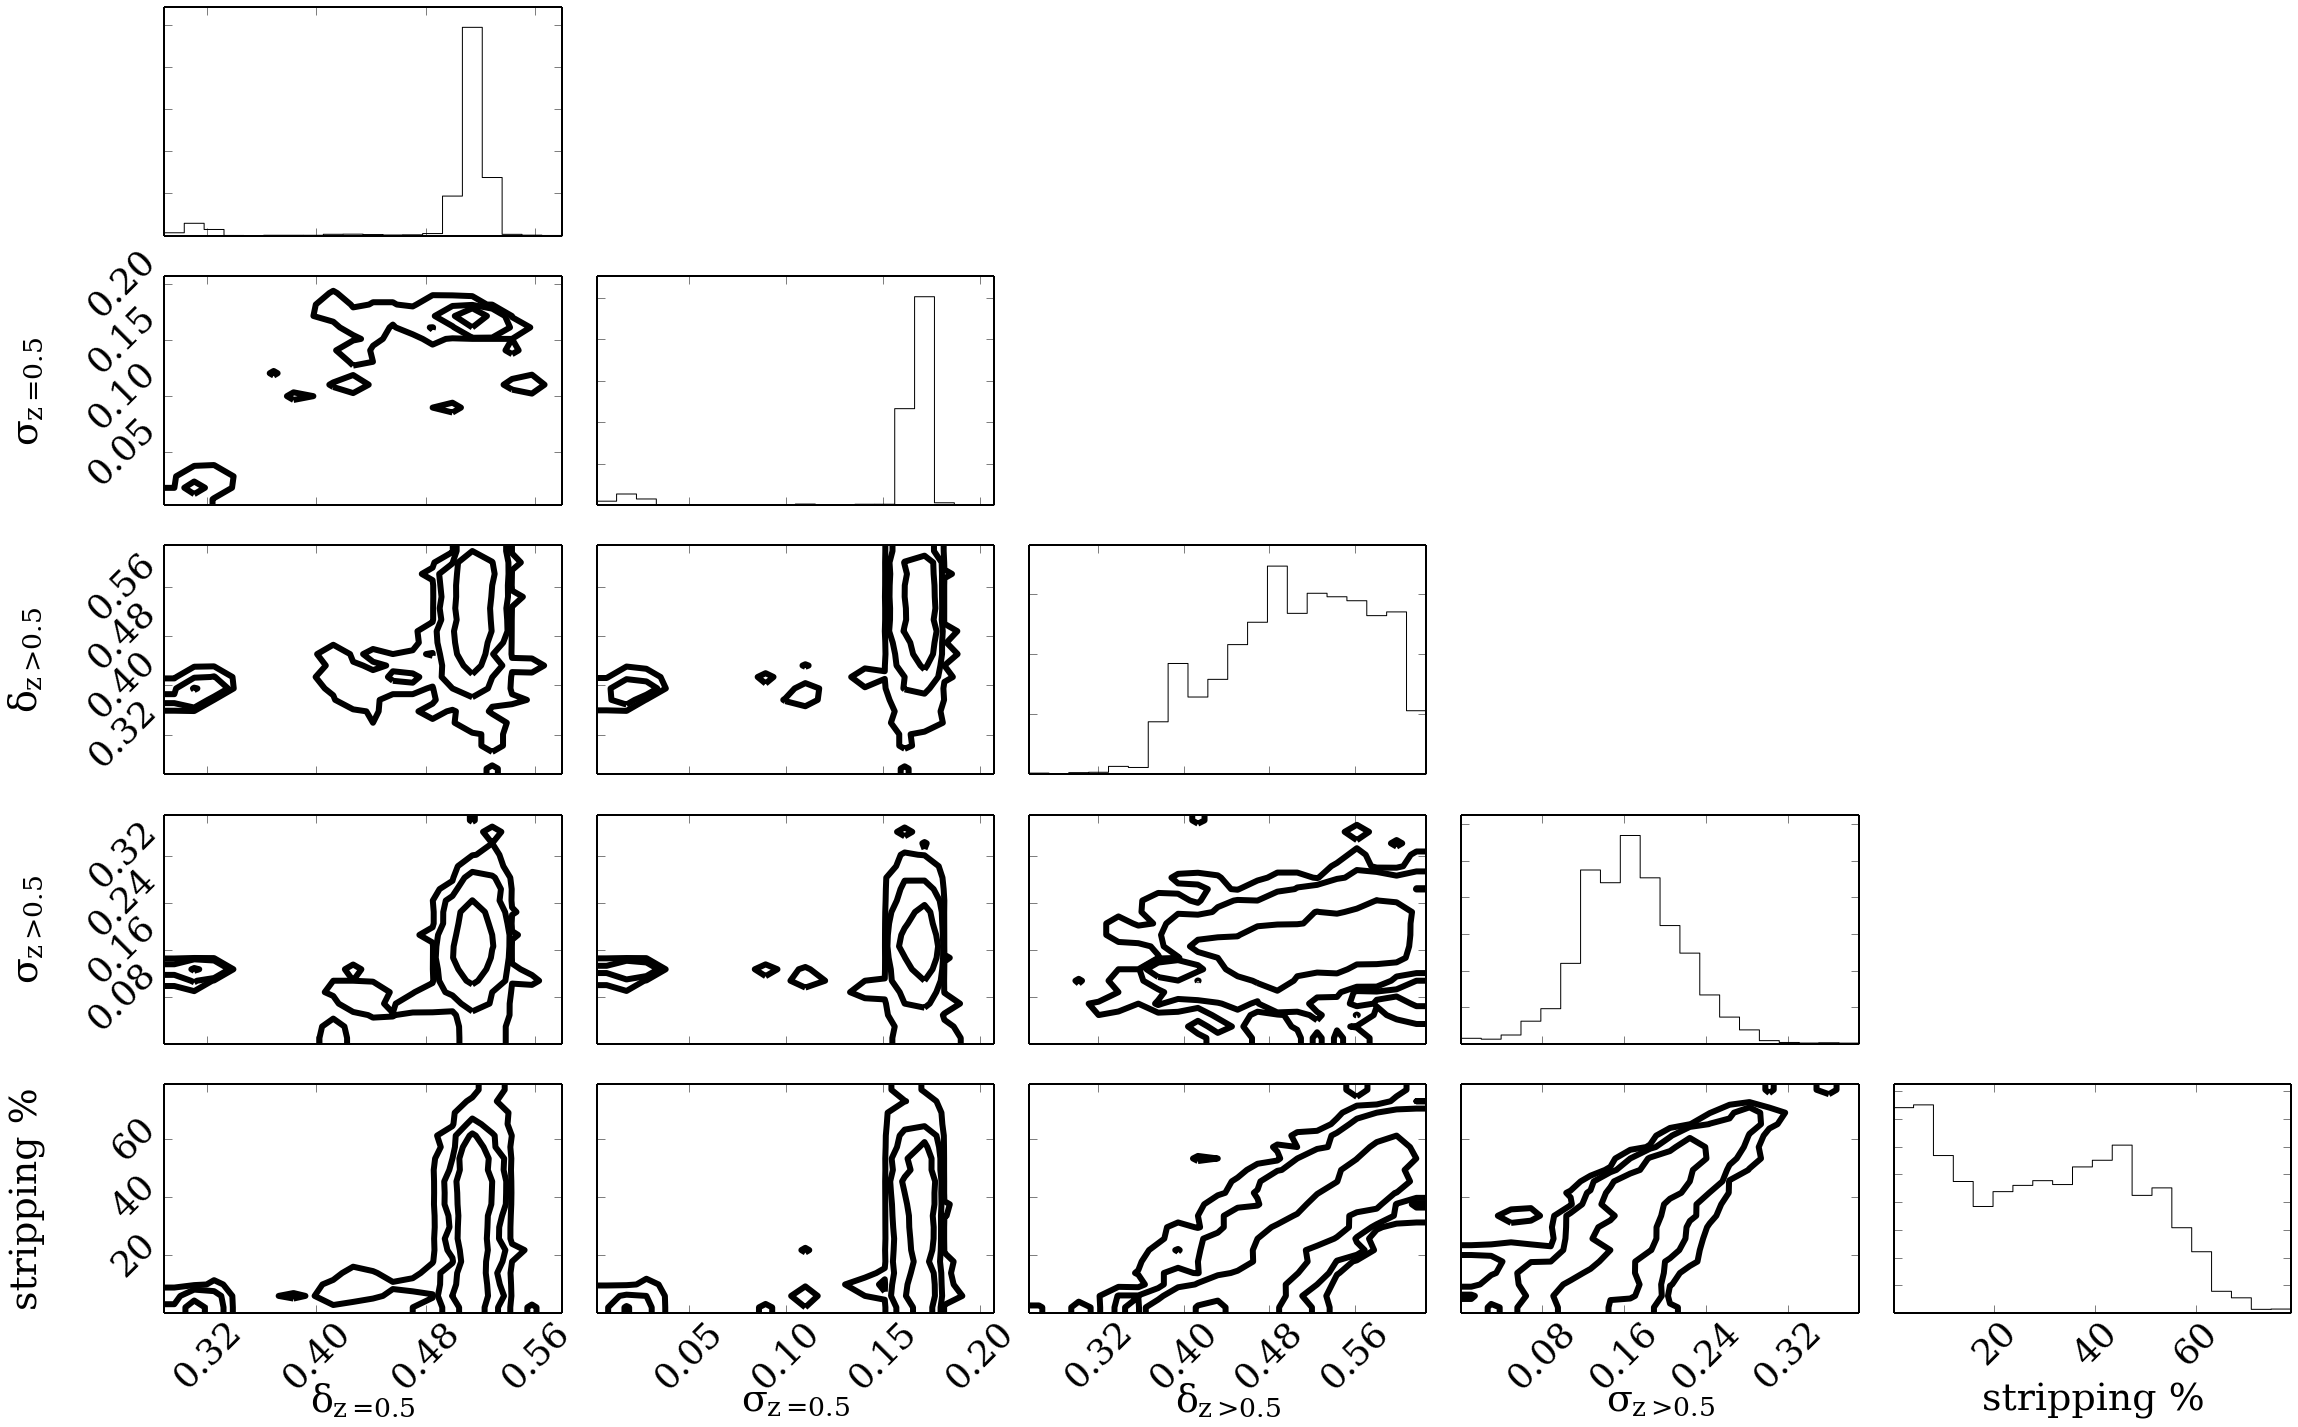

In [47]:
#print(pos)

#"""
print(np.transpose(pos)[0])

#samples = sampler.chain[:,:,:2].reshape((-1, 2))#[:, 50:, :].reshape((-1, ndim))

#print(samples)
#for i in range(0,8):
#    plt.plot(sampler.chain[i,:,3].reshape(-1))
#plt.show()
#plt.plot(sampler.chain[:,:,0].reshape(-1))

#plt.show()

#"""

levels=[0.68,0.95,0.992]

del corner
import corner
#%matplotlib qt
samples = sampler.chain.reshape((-1, ndim))
samples=np.transpose([1.-samples.T[0],samples.T[2],1.-samples.T[1],samples.T[3],100.*(1.-samples.T[4])])
fig = corner.corner(samples, labels=["$\delta_{z=0.5}$","$\sigma_{z=0.5}$","$\delta_{z>0.5}$", "$\sigma_{z>0.5}$","stripping %"],plot_density=False,plot_datapoints=False, levels=levels)
fig.set_figwidth(32)
fig.set_figheight(20)

fig.tight_layout()
fig.savefig('tmp.png')
#"""

#sampler.k()

In [14]:
import sys
sys.path.append('/home/swb1g09')
from mil_constants import *



def starformation(logm,logz1,logz2):
    ##returns log(new stars) between log(z1+1.) and log(z2+1) (z1>z2) for galaxy with log(Mstar)
    logA11=np.log10(0.0324)+11
    alpha=3.45
    beta=-0.35
    dmdt=10**(logA11+(beta+1)*(logm-11.)+alpha*logz1) #Peeples & Somerville 2013
    #print logz1,get_time_from_redshift(logz1),logz2,get_time_from_redshift(logz2)
    dt=get_time_from_redshift(logz2)-get_time_from_redshift(logz1)
    #print dt,dmdt,dm
    dm=np.log10(dmdt*dt)
    #print dt,dmdt/10**9,dm,logz1,logz2,logm
    return dm

def get_time_from_redshift(logz):
    #returns time in Gyrs after big bang
    if(omegaM==1):
        return 9.777505969*(2./3./h)*(10**(-logz*3./2.))
    else:
        return 9.777505969*(2./3/h/np.sqrt(1.-omegaM))*np.arcsinh(np.sqrt((1.-omegaM)/omegaM)/pow(10,(logz*(3./2))))

    
z=np.append(z,[0.])
time=get_time_from_redshift(np.log10(z+1.))
mi=[10.39]

for j in range(len(mi)):
    m_try=np.zeros(len(z))
    dm=np.zeros(len(z))
    loss=0.
    m_try[0]=mi[j]
    for i in range(len(z)-1):
        dm[i]=starformation(m_try[i],np.log10(z[i]+1.),np.log10(z[i+1]+1.))
        f=0.05*(np.log(1.+(time[i]-time)*1000/1.4))
        where_are_NaNs = np.isnan(f)
        f[where_are_NaNs] = 0
        m_try[i+1]=np.log10(10**m_try[i] + 10**dm[i] +loss - np.sum((10**dm)*f))
        loss=np.sum((10**dm)*f)

In [15]:
print(sampler.lnprobability)

[[ -4.52164524e+02  -3.13367863e+02  -7.17785032e+01 ...,  -7.37409545e+00
   -7.44003595e+00  -7.44003595e+00]
 [ -5.96511777e+03  -5.96511777e+03  -5.96511777e+03 ...,  -6.53355481e+00
   -6.53355481e+00  -6.53355481e+00]
 [ -3.73674228e+04  -3.09154856e+03  -3.09154856e+03 ...,  -7.09089552e+00
   -7.09089552e+00  -7.09089552e+00]
 ..., 
 [ -6.33909854e+03  -6.33909854e+03  -5.14886771e+03 ...,  -5.96673286e+00
   -5.88379747e+00  -5.88379747e+00]
 [ -3.57281417e+03  -3.57281417e+03  -1.98833894e+03 ...,  -6.92280573e+00
   -6.39393044e+00  -6.53076129e+00]
 [ -2.00268058e+03  -2.00268058e+03  -2.00268058e+03 ...,  -6.96188345e+00
   -7.27373224e+00  -7.22763429e+00]]


'\nfor i in Boundry.z_inf:\n    if np.sum(Sats.z_inf==i)==0:\n        if np.sum((Sats.z_inf<i+0.01) & (Sats.z_inf>i-0.01))>0:\n            Sats.z_inf[((Sats.z_inf<i+0.01) & (Sats.z_inf>i-0.01))]=i\n\n\n\nfor i in Boundry.z_inf:\n    if np.sum(Sats.z_inf==i)==0:\n        print(i)\n\n\nfor i in np.arange(0.03,0.301,0.03):\n    Sats.BoundryMass-=np.log10(1-0.03)\n    #print(Sats.BoundryMass)\n    #print(Sats.BoundryMass.values[0],10**(11.45-Sats.BoundryMass.values[0]))\n    cent_P,sat_P,cents_std,sats_std=model(0.65,0.51,0.15,0.15)\n    sat_P=np.array(sat_P)\n    cent_P=np.array(cent_P)\n    #print(sat_P)\n    print((np.sum(sat_P)/len(sat_P))/((np.sum(sat_P)/len(sat_P))+(np.sum(cent_P)/len(cent_P))))\n    plt.scatter(100.*i,(np.sum(sat_P)/len(sat_P))/((np.sum(sat_P)/len(sat_P))+(np.sum(cent_P)/len(cent_P))))\nplt.ylabel("fsat")\nplt.xlabel("% stripping")\nplt.show()\n'

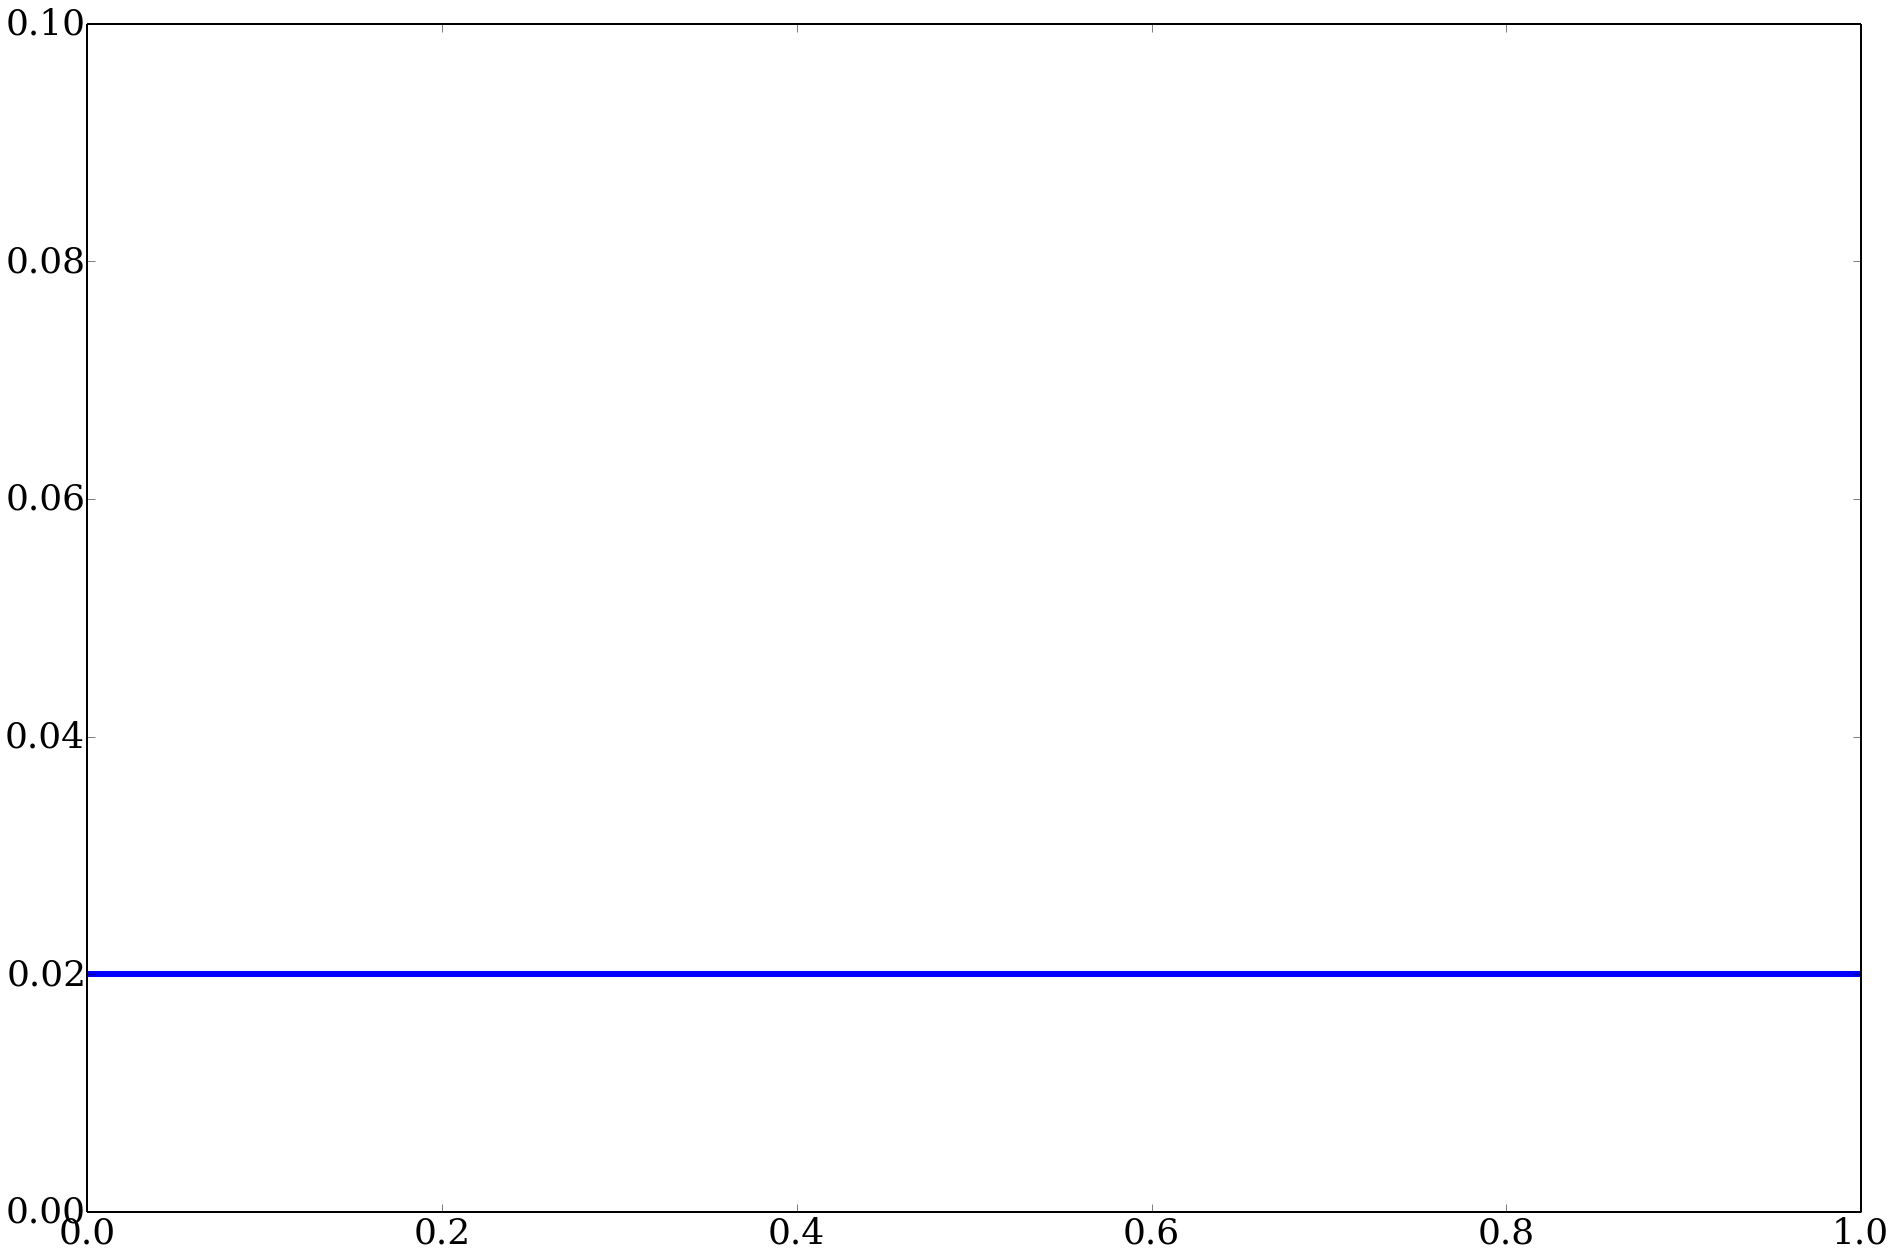

In [25]:
try:
    Sats = Sats.drop('BoundryMass', 1)
except:
    pass

#m_sat_boundry=m_try
z_boundry=z
m_sat_boundry=np.ones(len(z_boundry))*11.45
d={'BoundryMass' : m_sat_boundry, 'z_inf': z_boundry}
Boundry=pd.DataFrame(d)
Boundry.z_inf=Boundry.z_inf.astype(np.float)
Sats.z_inf=Sats.z_inf.astype(np.float)
Sats=pd.merge(Sats,Boundry,right_on='z_inf',left_on='z_inf',sort=False,copy=False,how='left')

#m_sat_boundry=np.ones(len(z_boundry))*11.45
#Sats.BoundryMass=11.45
cent_P,sat_P,cents_std,sats_std=model(0.55,0.48,0.14,0.16,0.9)
f0=(np.sum(sat_P)/len(sat_P))/((np.sum(sat_P)/len(sat_P))+(np.sum(cent_P)/len(cent_P)))
plt.axhline(f0)
plt.ylim(0,0.1)

"""
for i in Boundry.z_inf:
    if np.sum(Sats.z_inf==i)==0:
        if np.sum((Sats.z_inf<i+0.01) & (Sats.z_inf>i-0.01))>0:
            Sats.z_inf[((Sats.z_inf<i+0.01) & (Sats.z_inf>i-0.01))]=i



for i in Boundry.z_inf:
    if np.sum(Sats.z_inf==i)==0:
        print(i)


for i in np.arange(0.03,0.301,0.03):
    Sats.BoundryMass-=np.log10(1-0.03)
    #print(Sats.BoundryMass)
    #print(Sats.BoundryMass.values[0],10**(11.45-Sats.BoundryMass.values[0]))
    cent_P,sat_P,cents_std,sats_std=model(0.65,0.51,0.15,0.15)
    sat_P=np.array(sat_P)
    cent_P=np.array(cent_P)
    #print(sat_P)
    print((np.sum(sat_P)/len(sat_P))/((np.sum(sat_P)/len(sat_P))+(np.sum(cent_P)/len(cent_P))))
    plt.scatter(100.*i,(np.sum(sat_P)/len(sat_P))/((np.sum(sat_P)/len(sat_P))+(np.sum(cent_P)/len(cent_P))))
plt.ylabel("fsat")
plt.xlabel("% stripping")
plt.show()
"""

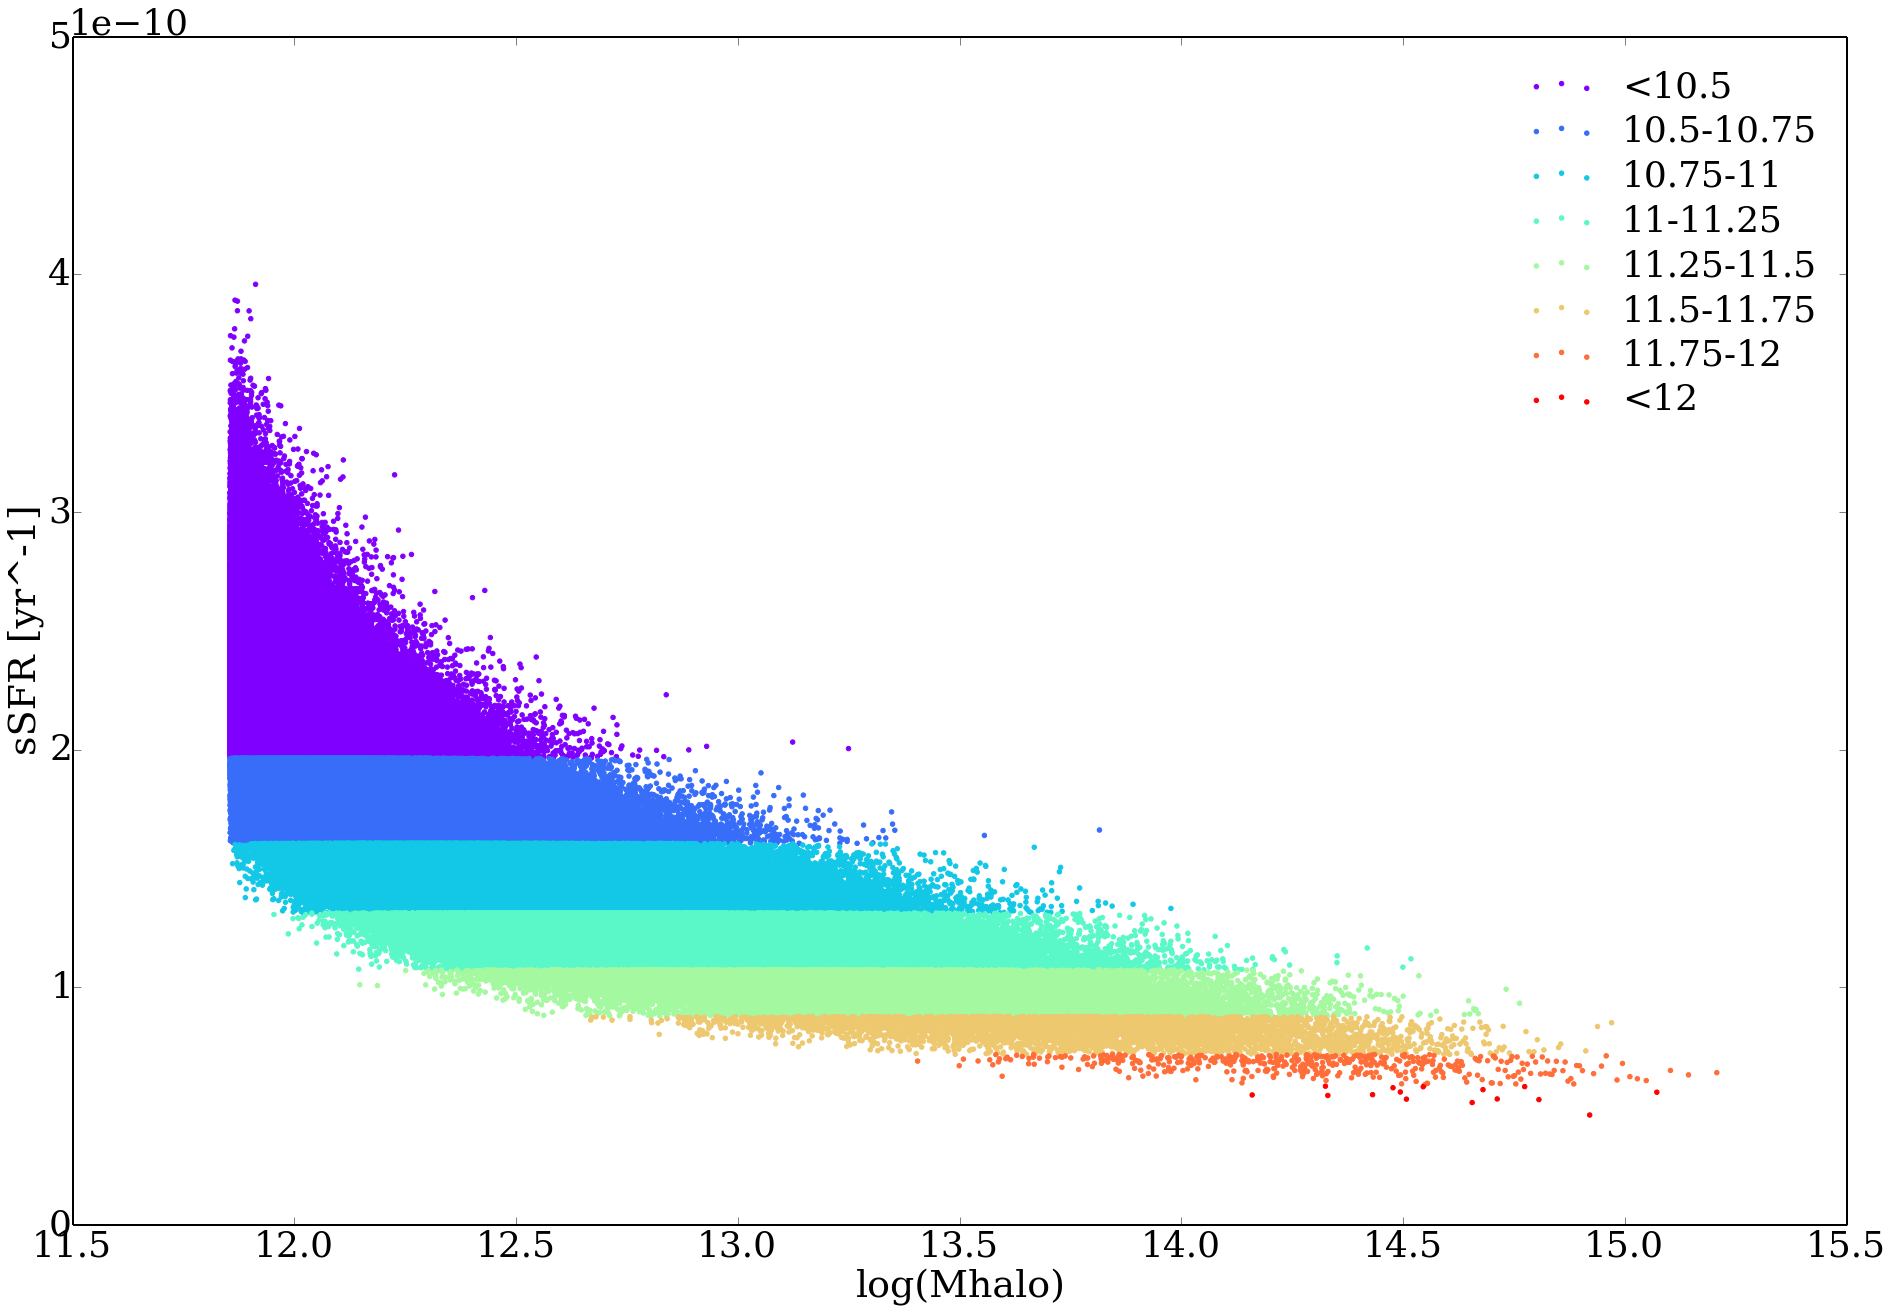

In [24]:
def starformation_2(logm,logz1):
    ##returns sSSR
    logA11=np.log10(0.0324)+11
    alpha=3.45
    beta=-0.35
    dm=10**(logA11+(beta+1)*(logm-11.)+alpha*logz1-logm) #Peeples & Somerville 2013
    return dm/(10**9)

#print(starformation_2(11,0))

#print(Cents.head().mstar.values)
bins = 10**np.linspace(10.5,12,7)

labels=iter(['<10.5','10.5-10.75','10.75-11','11-11.25','11.25-11.5','11.5-11.75','11.75-12','<12'])

groups = Cents.groupby(np.digitize(Cents.mstar, bins))
colors = iter(cm.rainbow(np.linspace(0, 1, len(groups))))
for B,I in groups:
    plt.scatter(np.log10(I.M200c),starformation_2(np.log10(I.mstar.values),np.log10(1.5)),color=next(colors),label=next(labels))
plt.ylim(0,5e-10)
plt.xlabel('log(Mhalo)')
plt.ylabel('sSFR [yr^-1]')
plt.legend()
plt.show()
#print(groups)
#print(starformation_2(np.log10(Cents.mstar.values),np.log10(1.5)))
#plt.hist(np.log10(Cents.mstar.values))

In [ ]:
print(I)


In [47]:
print(Sats)

        sdfsdaa    ID         M200c         M200b ID_host    M200c_host  \
0             1  crap  7.253489e+11  7.253489e+11    crap  1.019769e+12   
1             2  crap  7.412607e+11  7.412607e+11    crap  1.023533e+12   
2             3  crap  7.166283e+11  7.166283e+11    crap  1.027311e+12   
3             4  crap  7.951919e+11  7.951919e+11    crap  1.031103e+12   
4             5  crap  7.788592e+11  7.788592e+11    crap  1.034909e+12   
5             6  crap  7.198217e+11  7.198217e+11    crap  1.038728e+12   
6             7  crap  8.252014e+11  8.252014e+11    crap  1.042562e+12   
7             8  crap  7.565732e+11  7.565732e+11    crap  1.046410e+12   
8             9  crap  8.282643e+11  8.282643e+11    crap  1.050272e+12   
9            10  crap  8.269704e+11  8.269704e+11    crap  1.054149e+12   
10           11  crap  7.771090e+11  7.771090e+11    crap  1.058040e+12   
11           12  crap  8.030692e+11  8.030692e+11    crap  1.061945e+12   
12           13  crap  7.

In [44]:
corner.corner?

